# Caso 1: Modelo de Clasificación Binaria
Desarrollado por Bastián Reyes

## Imports

### Librerías:

In [349]:
import pandas as pd # Manejo de Datos
import seaborn as sns # Creación de Gráficos
import matplotlib.pyplot as plt #Creación de Gráficos
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score

### Dataset

In [350]:
df= pd.read_csv("dataset_Caso_1.csv") # Cargar el dataset
df.head(5) # Mostrar las primeras filas del dataset

,x1,x2,x3,x4,x5,x6,x7,x8,target
0,50.1341,-326.0000,SAT,MZBER,0,0,6,-6.5,0
1,50.1341,-326.0000,SAT,MZBER,0,0,6,-4.5,0
2,124.3276,-275.1935,LCV,MZBER,0,0,3,-2.5,0
3,50.1341,-326.0000,SAT,MZBER,0,0,3,-4.5,0
4,85.3905,-298.8632,XJB,MZBER,0,0,5,-4.5,0


## Preliminares

Revisión de la base de datos.

In [351]:
df.isnull().sum() # Revisar que no existan celdas vacías

x1        0
x2        0
x3        0
x4        0
x5        0
x6        0
x7        0
x8        0
target    0
dtype: int64

Se puede observar que no existen celdas vacías en el dataset.

In [352]:
df.dtypes # Mostrar los tipos de datos

x1        float64
x2        float64
x3         object
x4         object
x5          int64
x6          int64
x7          int64
x8        float64
target      int64
dtype: object

Para referencia se crea un gráfico mostrando la cantidad de datos para los valores de `target`.

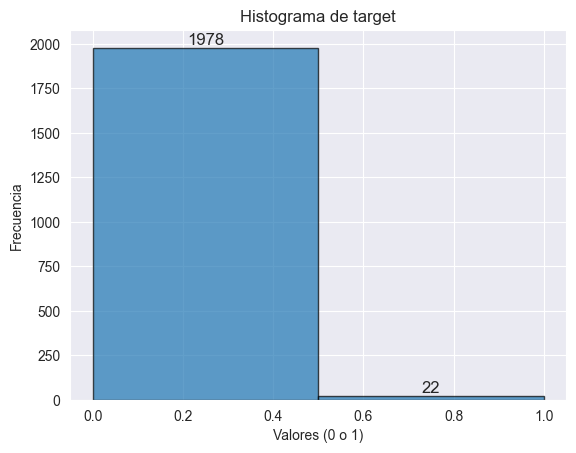

In [353]:
counts, bins, patches = plt.hist(df['target'], bins=2, edgecolor='black', alpha=0.7) # Crear el histograma

plt.title('Histograma de target')# Título
plt.xlabel('Valores (0 o 1)') #label x
plt.ylabel('Frecuencia') #label y

# Agregar cantidad exacta sobre cada barra
for count, patch in zip(counts, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height, str(int(count)),
             ha='center', va='bottom', fontsize=12)

# Mostrar el gráfico
plt.show()

Se puede observar que hay una cantidad notablemente mayor de registros con `target=0`, por lo que la base de datos está desbalanceada.

Las variables `x1`, `x2`, `x5`, `x6`, `x7` y `x8` son numéricas, por lo que se crea una tabla para observar sus valores mínimos y máximos.

In [354]:
variables= ['x1','x2','x5', 'x6', 'x7', 'x8'] # Listado de variables numéricas
tabla_resumen = pd.DataFrame({
    'Variable': variables, #Nombre de la variable
    'Tipo': [df[var].dtype for var in variables], # tipo float o int
    'Mínimo': [df[var].min() for var in variables], # valor mínimo
    'Máximo': [df[var].max() for var in variables] # valor máximo
})
tabla_resumen['Tipo'] = tabla_resumen['Tipo'].astype(str) # Convertir tipo a str para que se vea claro

print(tabla_resumen)

  Variable     Tipo    Mínimo    Máximo
0       x1  float64   50.1341  150.1341
1       x2  float64 -326.0000 -226.0000
2       x5    int64    0.0000    1.0000
3       x6    int64    0.0000    1.0000
4       x7    int64    3.0000    8.0000
5       x8  float64   -7.5000   -1.5000


Para las variables categóricas se hace una tabla similar contando la cantidad de valores únicos y un listado de estos

In [355]:
columnas_categoricas = ['x3', 'x4']# Seleccionar solo las columnas categóricas

# Crear la tabla con el conteo y la lista de valores distintos
tabla = pd.DataFrame({
    'Columna': columnas_categoricas,
    'Valores_Distintos': [df[col].nunique() for col in columnas_categoricas],
    'Lista_Valores': [df[col].unique().tolist() for col in columnas_categoricas]
})

print(tabla)

  Columna  Valores_Distintos              Lista_Valores
0      x3                  4       [SAT, LCV, XJB, QKP]
1      x4                  4  [MZBER, PQKE, YEQA, ZUQF]


## Revisión de Variables

Por lo visto en la tabla de variables numéricas, las variables `x1`, `x2` y `x8` son continuas, por lo que se hacen gráficos boxplot de cada una

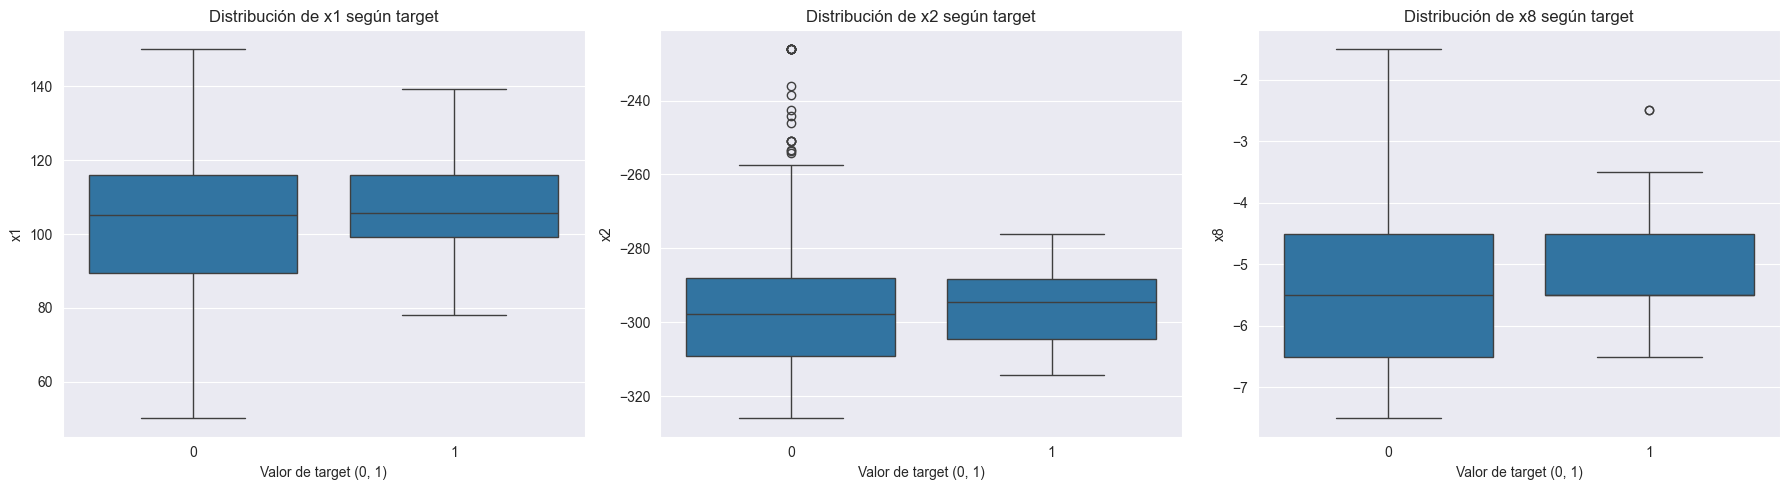

In [356]:
var_num = ['x1', 'x2', 'x8'] #Seleccionar las variables
# Crear la figura y los ejes para 1 fila y 3 columnas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Aplanar la matriz de ejes para facilitar la iteración
axes = axes.flatten()
# Generar cada boxplot
for i, var in enumerate(var_num):
    sns.boxplot(data=df, x='target', y=var, ax=axes[i])
    axes[i].set_title(f'Distribución de {var} según target')
    axes[i].set_xlabel('Valor de target (0, 1)')
    axes[i].set_ylabel(var)

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

En los tres gráficos se puede notar que solamente para un intervalo menor al de la variable, `target` toma el valor 1, lo que indica que pueden ser relevantes para la clasificación. Además hay que mencionar que las variables  `x1` y `x2` tienen escalas muy distintas a las otras variables, por lo que se deberían normalizar.

De esto se puede destacar que `x5` y `x6` son variables binarias, a continuación se hacen gráficos para ver el comportamiento de ambas variables respecto al valor de `target`

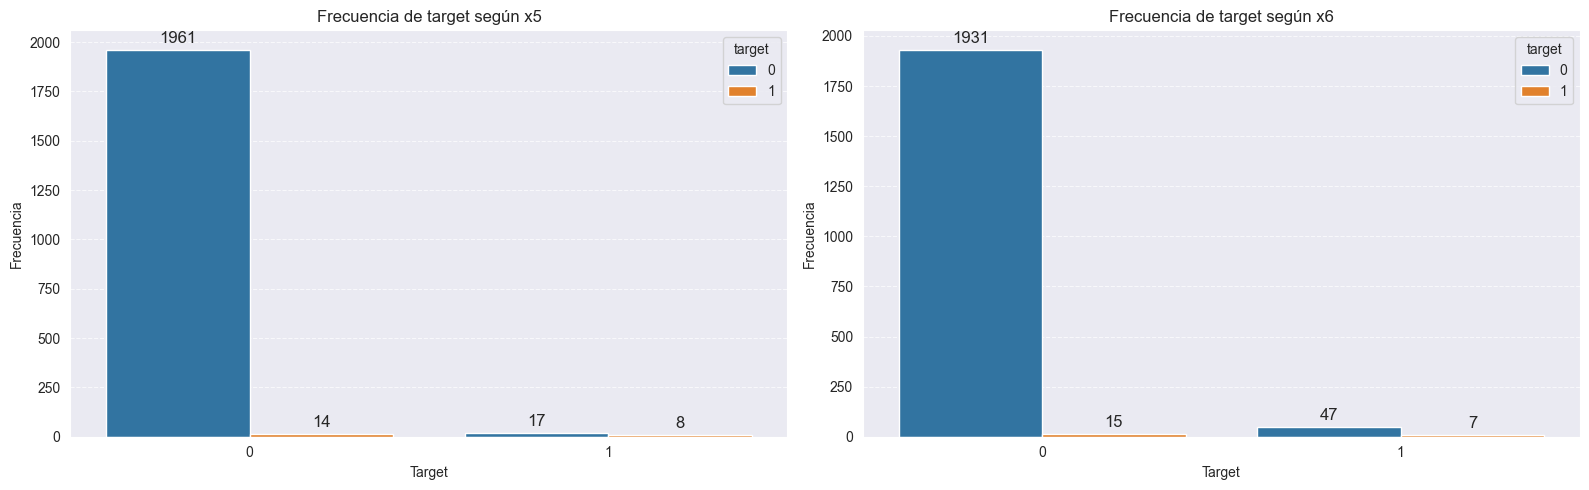

In [357]:
# Crear subgráficos (subplots) en una fila y dos columnas
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico para x5 con respecto a target
sns.countplot(data=df, x='x5', hue='target', ax=axes[0])

# Agregar etiquetas con los valores exactos en el gráfico de x5
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', label_type='edge', fontsize=12, padding=3)

# Personalización del gráfico de x5
axes[0].set_xlabel("Target")
axes[0].set_ylabel("Frecuencia")
axes[0].set_title("Frecuencia de target según x5")
axes[0].set_xticks([0, 1])
axes[0].grid(axis="y", linestyle="--", alpha=0.7)
axes[0].legend(title="target")

# Gráfico para x6 con respecto a target
sns.countplot(data=df, x='x6', hue='target', ax=axes[1])

# Agregar etiquetas con los valores exactos en el gráfico de x6
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%d', label_type='edge', fontsize=12, padding=3)

# Personalización del gráfico de x6
axes[1].set_xlabel("Target")
axes[1].set_ylabel("Frecuencia")
axes[1].set_title("Frecuencia de target según x6")
axes[1].set_xticks([0, 1])
axes[1].grid(axis="y", linestyle="--", alpha=0.7)
axes[1].legend(title="target")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

De estos gráficos se puede observar que cuando `x5` toma valor 1, el valor de `target` sigue siendo mayormente 0, pero lo que cambia es la proporción entre los valores de `target`, los 0s dejan de ser una cantidad gigantesca comparada con los 1s. Lo mismo se puede decir para el caso de `x6`. Cabe mencionar de que esto se puede deber a la poca cantidad de registros donde `target`, `x5` y `x6` tienen valor 1.

Para `x7` se hace también un histograma con barras agrupadas, dado que es una variable discreta.

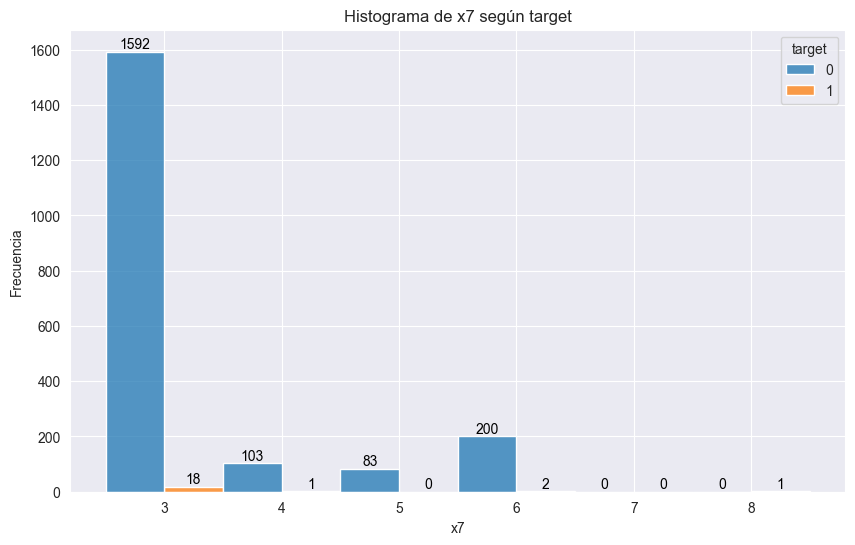

In [358]:
# Crear la figura
plt.figure(figsize=(10, 6))

# Histograma con barras separadas
ax = sns.histplot(data=df, x='x7', hue='target', multiple='dodge', discrete=True)

# Agregar etiquetas con la frecuencia exacta sobre cada barra
for p in ax.patches:
    ax.annotate(int(p.get_height()),  # Convertimos la altura a entero para mostrar sin decimales
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Posición del texto
                ha='center', va='bottom', fontsize=10, color='black')

# Personalización del gráfico
plt.title('Histograma de x7 según target')
plt.xlabel('x7')
plt.ylabel('Frecuencia')

plt.show()

En este gráfico se puede notar que para valores menores o iguales a 6 para `x7`, se obtiene principalmente el valor 0 de `target`, mientras que para el valor 8 se obtiene el valor 1 de `target`, pero esto es debido a la falta de datos para valores 1, lo que puede significar que esta variable no sea muy beneficiosa para el modelo.

Para las variables categóricas se hace el mismo tipo de gráfico

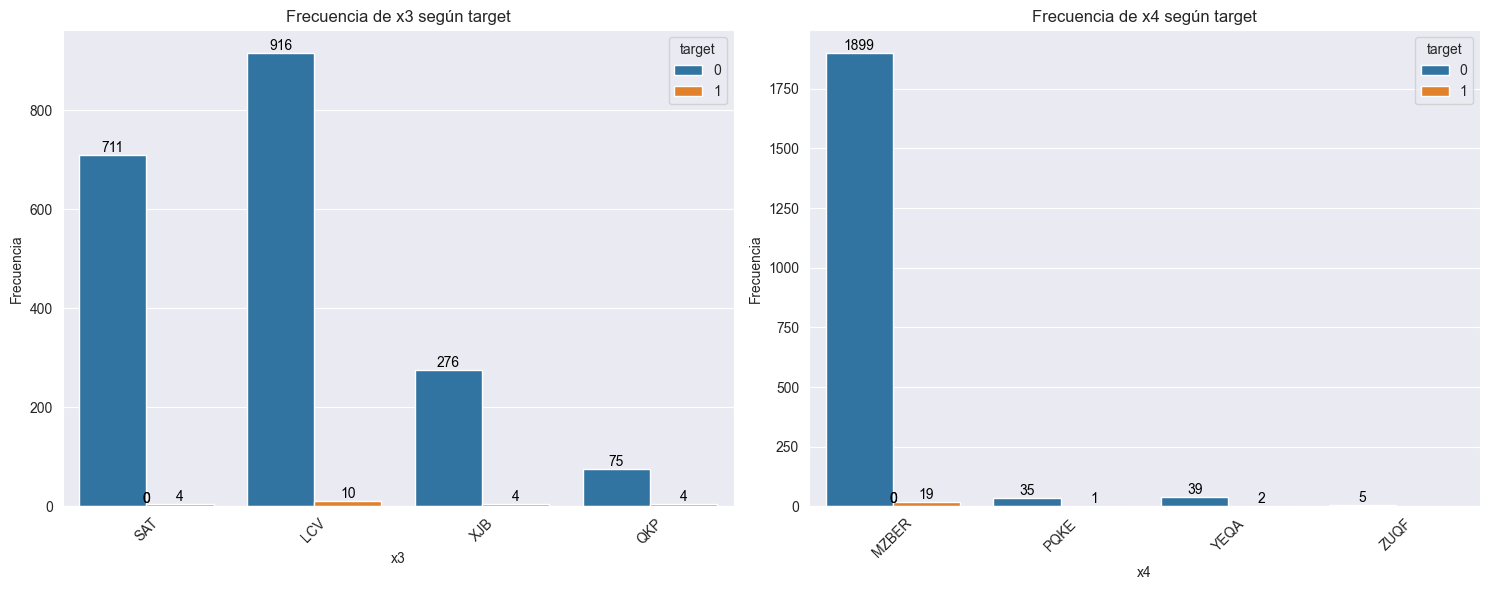

In [359]:
# Crear la figura con dos subgráficos en una fila
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras para x3
ax1 = sns.countplot(data=df, x='x3', hue='target', dodge=True, ax=axes[0])
ax1.set_title('Frecuencia de x3 según target')
ax1.set_xlabel('x3')
ax1.set_ylabel('Frecuencia')

# Agregar etiquetas de frecuencia sobre las barras de x3
for p in ax1.patches:
    ax1.annotate(int(p.get_height()),
                 (p.get_x() + p.get_width() / 2, p.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black')

# Gráfico de barras para x4
ax2 = sns.countplot(data=df, x='x4', hue='target', dodge=True, ax=axes[1])
ax2.set_title('Frecuencia de x4 según target')
ax2.set_xlabel('x4')
ax2.set_ylabel('Frecuencia')

# Agregar etiquetas de frecuencia sobre las barras de x4
for p in ax2.patches:
    ax2.annotate(int(p.get_height()),
                 (p.get_x() + p.get_width() / 2, p.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black')

# Rotar etiquetas de categorías en el eje X para ambos gráficos
plt.setp(ax1.get_xticklabels(), rotation=45)
plt.setp(ax2.get_xticklabels(), rotation=45)

# Ajustar diseño para evitar superposición
plt.tight_layout()

# Mostrar los gráficos
plt.show()

En el gráfico de `x3` se puede ver que para todos los valores de la variable, es más probable que se obtenga un valor 0 de `target`, aunque similar a los casos de `x5` y `x6` se puede notar un cambio en las proporciones de los valores de `target` de acuerdo a los valores de `x3`. De todas formas, el desbalance del dataset puede estar afectando esto.
En el caso de `x4` también se podría mencionar lo del cambio de proporciones, pero este se ve mucho más afectado por el desbalance.

Ahora se realiza una matriz de correlación

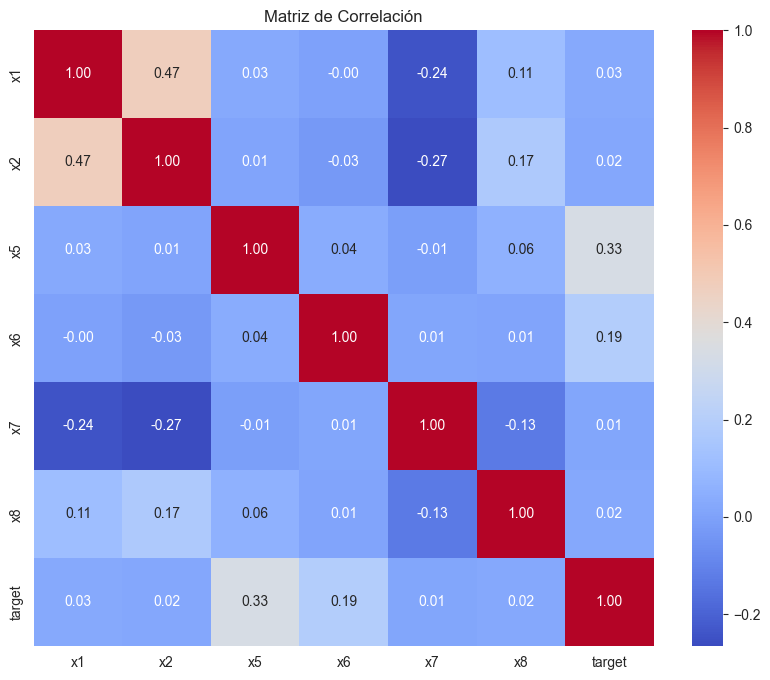

In [360]:
# Filtrar solo las columnas numéricas
df_numeric = df.select_dtypes(include=['number'])

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

# Graficar el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

En la matriz se puede notar que `x1` y `x2` están bastante correlacionadas entre si, por lo que para el modelo convendría eliminar una de estas. Además se puede observar que de todas las variables, `x5` está bastante correlacionada con `target`, por lo que conviene mantenerla en el modelo.

## Modificación de Variables.
Como fue mencionado anteriormente, dado que las escalas de `x1` y `x2` son muy diferentes al resto de las variables, conviene normalizarlas. En este caso utilizando Min-Max Scaling.

In [361]:
columns_to_normalize = ['x1', 'x2'] #Seleccionar columnas

scaler = MinMaxScaler()# Crear el escalador

dfn=df.copy() #Crear un nuevo dataser en base al original para ser modificado

dfn[columns_to_normalize] = scaler.fit_transform(dfn[columns_to_normalize])# Aplicar transformación a las columnas seleccionadas
dfn.head()# Mostrar resultados

,x1,x2,x3,x4,x5,x6,x7,x8,target
0,0.000000,0.000000,SAT,MZBER,0,0,6,-6.5,0
1,0.000000,0.000000,SAT,MZBER,0,0,6,-4.5,0
2,0.741935,0.508065,LCV,MZBER,0,0,3,-2.5,0
3,0.000000,0.000000,SAT,MZBER,0,0,3,-4.5,0
4,0.352564,0.271368,XJB,MZBER,0,0,5,-4.5,0


Dado que las variables `x3` y `x4` están compuestas de strings, es mejor pasarlas a variables dummy para evitar problemas más adelante de modelos tratando de pasar strings a números.

In [362]:
dfn = pd.get_dummies(dfn, columns=['x3', 'x4'], drop_first=True)# Creación de variables dummy para x3 y x4
dfn[dfn.select_dtypes(include=['bool']).columns] = dfn.select_dtypes(include=['bool']).astype(int)# convertir booleanos a 0 y 1
dfn.head() #mostrar el dataset modificado

,x1,x2,x5,x6,x7,x8,target,x3_QKP,x3_SAT,x3_XJB,x4_PQKE,x4_YEQA,x4_ZUQF
0,0.000000,0.000000,0,0,6,-6.5,0,0,1,0,0,0,0
1,0.000000,0.000000,0,0,6,-4.5,0,0,1,0,0,0,0
2,0.741935,0.508065,0,0,3,-2.5,0,0,0,0,0,0,0
3,0.000000,0.000000,0,0,3,-4.5,0,0,1,0,0,0,0
4,0.352564,0.271368,0,0,5,-4.5,0,0,0,1,0,0,0


Por último se imprimen los nombres de las columnas del dataset para ser utilizados en la creación del modelo.

In [363]:
column_names = dfn.columns
print(column_names)

Index(['x1', 'x2', 'x5', 'x6', 'x7', 'x8', 'target', 'x3_QKP', 'x3_SAT',
       'x3_XJB', 'x4_PQKE', 'x4_YEQA', 'x4_ZUQF'],
      dtype='object')


## Creación del Modelo


Se seleccionó Logit como modelo para este caso principalmente por su simplicidad, dada la urgencia del contexto es rápido de utilizar y permite ajustar parámetros como las variables a utilizar y la realización de undersampling para trabajar con datos desbalanceados.

Para comenzar, se definen los sets de entrenamiento y testeo

In [364]:
X = dfn[[ 'x2', 'x5', 'x6', 'x7', 'x8', 'x3_QKP', 'x3_SAT','x3_XJB']] # Características Seleccionadas para el modelo
y = dfn['target']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) # Dividir en train y test

# Crear los DataFrames originales de train y test
dfn_train = X_train.copy()
dfn_train['target'] = y_train
dfn_test = X_test.copy()
dfn_test['target'] = y_test

# Aplicar Undersampling en el conjunto de entrenamiento
undersampler = RandomUnderSampler(sampling_strategy=0.75, random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Crear el DataFrame balanceado de entrenamiento
dfn_trainb = X_train_resampled.copy()
dfn_trainb['target'] = y_train_resampled

# Verificar la distribución de clases
print("Distribución original en Train:", y_train.value_counts().to_dict())
print("Distribución después del Undersampling:", y_train_resampled.value_counts().to_dict())
print("Distribución en Test (sin cambios):", y_test.value_counts().to_dict())

Distribución original en Train: {0: 1582, 1: 18}
Distribución después del Undersampling: {0: 24, 1: 18}
Distribución en Test (sin cambios): {0: 396, 1: 4}


De lo anterior, las variables a utilizar fueron seleccionadas en base a lo descubierto durante la evaluación de los datos (Se debía eliminar `x1` o `x2`, y `x4` no era útil para el modelo) y también en base a la realización de pruebas con distinas variables y valores de estrategia de undersampling para mejorar los valores solicitados.

Con los valores ya definidos se creó el modelo y se obtuvieron los valores para AUC train, AUC test y F1.

In [365]:
# Crear el modelo de regresión logística
model = LogisticRegression(random_state=42)

# Entrenar el modelo con los datos balanceados
model.fit(X_train_resampled, y_train_resampled)

# Realizar predicciones en el conjunto de entrenamiento y prueba
y_train_pred_proba = model.predict_proba(X_train_resampled)[:, 1]  # Probabilidades para la clase positiva en train
y_test_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva en test

# Calcular el AUC para entrenamiento y prueba
auc_train = roc_auc_score(y_train_resampled, y_train_pred_proba)
auc_test = roc_auc_score(y_test, y_test_pred_proba)

# Calcular F1-score para test (puedes calcularlo también para train si lo prefieres)
f1_test = f1_score(y_test, model.predict(X_test))

# Mostrar los resultados
print(f"AUC en entrenamiento: {auc_train}")
print(f"AUC en prueba: {auc_test}")
print(f"F1-score en prueba: {f1_test}")

AUC en entrenamiento: 0.8680555555555555
AUC en prueba: 0.6452020202020202
F1-score en prueba: 0.13333333333333333
